# Dialogue Model Fine-Tuning - Love Is Blind (v3) 🤖

**Purpose:** Fine-tune LLaMA/Mistral models for dialogue generation using LoRA with pre-made dialogue pairs

**Version 2 Features:**
- 📊 Uses pre-created dialogue pairs (all 11 episodes combined)
- 🎭 Anonymizes character names for better generalization
  - Names in context → `[Agent]` (person being talked to)
  - Names in response → `[User]` (person being addressed by agent)
- 🚀 Faster data loading (no on-the-fly pair creation)

**What this notebook does:**
- 📚 Load pre-processed Love Is Blind dialogue pairs (~11,960 pairs)
- 🔄 Replace character names with generic placeholders
- 🎯 Fine-tune LLaMA/Mistral with LoRA (memory efficient)
- 🎭 Support both basic and emotion-conditioned modes
- 📊 Monitor training with live visualizations
- 💾 Save and test your fine-tuned model

**Single GPU Optimizations:**
- LoRA: Train <1% of parameters
- Gradient checkpointing: Reduce memory by ~40%
- Mixed precision (FP16): 2x faster training
- Gradient accumulation: Simulate larger batch sizes

**Memory Requirements:** ~12-14GB for LLaMA-7B

---

## 1. Setup and Configuration

In [1]:
!pip3 install torch
!pip3 install pandas
!pip3 install numpy
!pip3 install tqdm
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install transformers
!pip3 install datasets
!pip3 install accelerate
!pip3 install bitsandbytes
!pip3 install tensorboard
!pip3 install pyyaml
!pip3 install peft

In [2]:
# Check environment
import sys
from pathlib import Path

# Add parent to path
if Path.cwd().name == 'notebooks':
    sys.path.insert(0, str(Path.cwd().parent))
    print("✓ Running from notebooks directory")
else:
    print(f"⚠️  Current directory: {Path.cwd()}")
    print("Please run from notebooks/ directory")

✓ Running from notebooks directory


In [3]:
# Core imports
import torch
import json
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
import glob
import re

# Transformers and PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)
from datasets import Dataset, DatasetDict

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    
    # Clear cache
    torch.cuda.empty_cache()
else:
    print("⚠️  No GPU detected - training will be VERY slow")

Device: cuda
GPU: NVIDIA L40S
Memory: 47.67 GB
CUDA Version: 12.8


## 2. Training Configuration

**⚠️ CUSTOMIZE THESE SETTINGS:**

In [20]:
# ==================== CONFIGURATION ====================

# Model settings
MODEL_NAME = "meta-llama/Llama-2-7b-hf"  # or "mistralai/Mistral-7B-v0.1"
# Note: You'll need HuggingFace access token for LLaMA models

# Training mode
EMOTION_CONDITIONED = False  # Set True to include emotion labels

# Data paths - using pre-made dialogue pairs
DATA_PATTERN = "../data/processed/love_is_blind/*_dialogue_pairs.csv"
OUTPUT_DIR = "../checkpoints/dialogue_finetuned_v2"

# Character names to anonymize
NAMES = ["Lauren", "Speed", "Cameron", "Hamilton", "Amber", "Pike", "Matthew",
         "Barnett", "Giannina", "Gibelli", "Damian", "Powers", "Jessica",
         "Batten", "Mark", "Cuevas", "Kelly", "Chase", "Kenny", "Barnes",
         "Diamond", "Jack", "Carlton", "Morton", "Danielle", "Drouin", "Rory",
         "Newbrough", "Lexie", "Skipper", "Westley", "Baer", "Lauren", "LC",
         "Chamblin", "Alyson", "Costa", "Andy", "Rickert", "Briana", "Holmes",
         "Ebony", "Alexis", "India", "Bridgeforth", "Jon", "Smith", "Kay",
         "Mitchell", "Kenneth", "Smith", "Lillie", "Williams", "Matt",
         "Thomas", "Mikey", "Cobb", "Ryan", "Martin", "Taylor", "Lupton",
         "Westley", "Baer", "Iyanna", "McNeely",
         "Jarrette", "Jones", "Danielle", "Ruhl", "Nick", "Thompson",
         "Natalie", "Lee", "Shayne", "Jansen", "Deepti", "Vempati",
         "Abhishek", "Shake", "Chatterjee", "Mallory", "Zapata",
         "Salvador", "Perez", "Shaina", "Hurley", "Kyle", "Abrams",
         "Caitlin", "McKee", "James", "Joey", "Miller", "Kara", "Williams",
         "Jason", "Beaumont", "Aja", "Johnson", "Brandon", "McGhee",
         "Brian", "Ngo", "Chassidy", "Mickale", "Haseeb", "Hussain",
         "Hope", "Antoniello", "Jeremy", "Hartwell", "Juhie", "Faheem",
         "Julius", "Cacho", "Olivia", "Harris", "Rocky", "Smith", "Shea'na", "Grigsby",
         "Trisha", "Frame", "Vito", "Salamone"]

# Training hyperparameters
CONFIG = {
    # Data
    'max_length': 256,  # Maximum sequence length
    'train_split': 0.7,  # 90% train, 10% validation
    
    # Training
    'num_epochs': 8,
    'batch_size': 8,  # Per-device batch size (small for memory)
    'gradient_accumulation_steps': 8,  # Effective batch = 1 * 8 = 8
    'learning_rate': 2e-4,
    'warmup_steps': 100,
    'weight_decay': 0.01,
    
    # LoRA parameters
    'lora_r': 8,  # LoRA rank (higher = more params, better quality)
    'lora_alpha': 16,  # LoRA alpha (scaling factor)
    'lora_dropout': 0.05,
    'lora_target_modules': ['q_proj', 'v_proj', 'k_proj', 'o_proj'],  # Which layers to adapt
    
    # Memory optimization
    'gradient_checkpointing': True,
    'fp16': True,  # Use mixed precision (set False if bf16 supported)
    'bf16': False,  # Use bfloat16 (better for newer GPUs like A100)
    
    # Logging
    'logging_steps': 10,
    'eval_steps': 100,
    'save_steps': 500,
    'save_total_limit': 5,  # Keep only 3 best checkpoints
}

# HuggingFace token (required for LLaMA)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print(f"\nData pattern: {DATA_PATTERN}")
print(f"Names to anonymize: {len(set(NAMES))} unique names")

Configuration:
  max_length: 256
  train_split: 0.7
  num_epochs: 8
  batch_size: 8
  gradient_accumulation_steps: 8
  learning_rate: 0.0002
  warmup_steps: 100
  weight_decay: 0.01
  lora_r: 8
  lora_alpha: 16
  lora_dropout: 0.05
  lora_target_modules: ['q_proj', 'v_proj', 'k_proj', 'o_proj']
  gradient_checkpointing: True
  fp16: True
  bf16: False
  logging_steps: 10
  eval_steps: 100
  save_steps: 500
  save_total_limit: 5

Data pattern: ../data/processed/love_is_blind/*_dialogue_pairs.csv
Names to anonymize: 118 unique names


## 3. Load and Explore Data

In [21]:
# Find all dialogue pairs files
dialogue_files = sorted(glob.glob(DATA_PATTERN))

print(f"Found {len(dialogue_files)} dialogue pairs files:")
for i, file in enumerate(dialogue_files, 1):
    print(f"  {i}. {file.split('/')[-1]}")

# Load and combine all files
dfs = []
for file in dialogue_files:
    temp_df = pd.read_csv(file)
    dfs.append(temp_df)
    print(f"  Loaded {len(temp_df)} pairs from {file.split('/')[-1]}")

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined dataset: {len(df)} dialogue pairs")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few samples:")
df.head(10)

Found 24 dialogue pairs files:
  1. Love Is Blind_ Season 1, Episode 1 script _ Subs like Script_dialogue_pairs.csv
  2. Love Is Blind_ Season 1, Episode 10 script _ Subs like Script_dialogue_pairs.csv
  3. Love Is Blind_ Season 1, Episode 11 script _ Subs like Script_dialogue_pairs.csv
  4. Love Is Blind_ Season 1, Episode 2 script _ Subs like Script_dialogue_pairs.csv
  5. Love Is Blind_ Season 1, Episode 3 script _ Subs like Script_dialogue_pairs.csv
  6. Love Is Blind_ Season 1, Episode 4 script _ Subs like Script_dialogue_pairs.csv
  7. Love Is Blind_ Season 1, Episode 5 script _ Subs like Script_dialogue_pairs.csv
  8. Love Is Blind_ Season 1, Episode 6 script _ Subs like Script_dialogue_pairs.csv
  9. Love Is Blind_ Season 1, Episode 7 script _ Subs like Script_dialogue_pairs.csv
  10. Love Is Blind_ Season 1, Episode 8 script _ Subs like Script_dialogue_pairs.csv
  11. Love Is Blind_ Season 1, Episode 9 script _ Subs like Script_dialogue_pairs.csv
  12. Love Is Blind_ Season 2,

,context,response
0,"When I heard about this experiment, I knew it ...","There's so many dating apps, and most of them ..."
1,It was the opposite of what modern dating has ...,"It's not all about physical attraction, in the..."
2,"There's so many dating apps, and most of them ...",It's who's holding your hand on your deathbed.
3,"It's not all about physical attraction, in the...",The reason I came here is there's men who actu...
4,It's who's holding your hand on your deathbed....,They're looking for wives.
5,The reason I came here is there's men who actu...,"I'm like, ""What? Where?"""
6,"They're looking for wives. I'm like, ""What? Wh...",Wow.
7,"I'm like, ""What? Where?"" Wow.",Hi!
8,Wow. Hi!,I'm Briana!
9,Hi! I'm Briana!,I really want a man who is going to love me fo...


Context Length Statistics:
count    26113.000000
mean        13.855551
std          9.054059
min          2.000000
25%          8.000000
50%         12.000000
75%         18.000000
max         97.000000
Name: context_length, dtype: float64

Response Length Statistics:
count    26113.000000
mean         6.926550
std          5.944749
min          1.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         82.000000
Name: response_length, dtype: float64


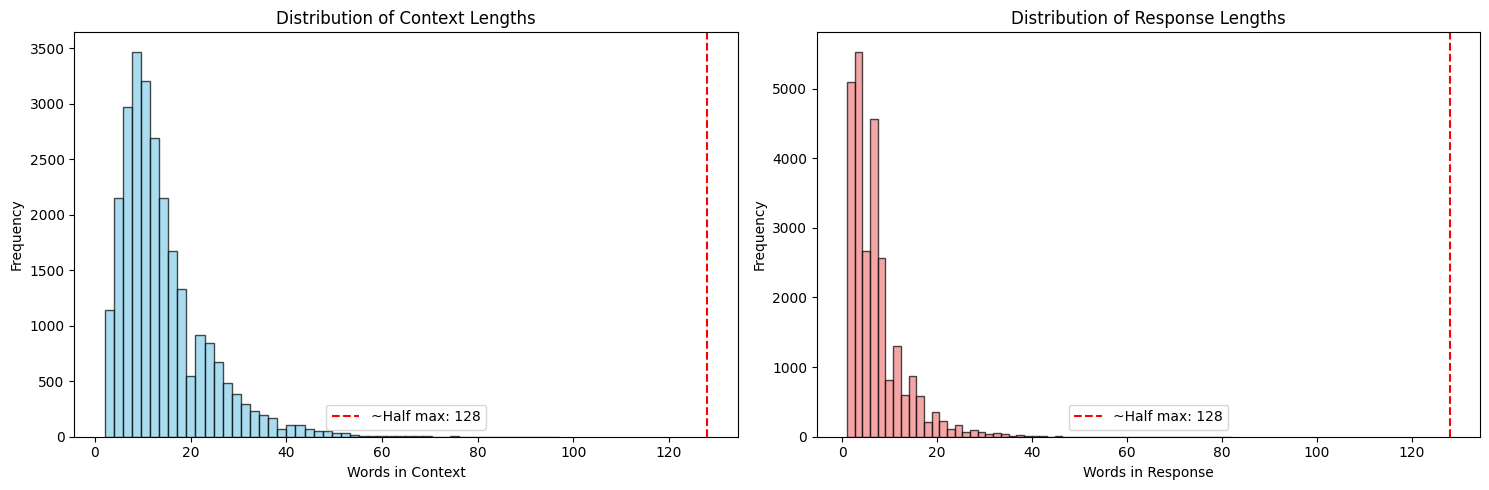

In [22]:
# Calculate text lengths for context and response
df['context_length'] = df['context'].str.split().str.len()
df['response_length'] = df['response'].str.split().str.len()

print("Context Length Statistics:")
print(df['context_length'].describe())
print("\nResponse Length Statistics:")
print(df['response_length'].describe())

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Context length distribution
axes[0].hist(df['context_length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Words in Context')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Context Lengths')
axes[0].axvline(CONFIG['max_length']//2, color='red', linestyle='--', label=f'~Half max: {CONFIG["max_length"]//2}')
axes[0].legend()

# Response length distribution
axes[1].hist(df['response_length'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Words in Response')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Response Lengths')
axes[1].axvline(CONFIG['max_length']//2, color='red', linestyle='--', label=f'~Half max: {CONFIG["max_length"]//2}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Name Anonymization

Replace character names with generic placeholders for better generalization:
- Names in **context** → `[Agent]` (the person being talked to)
- Names in **response** → `[User]` (the person being addressed by the agent)

In [23]:
def anonymize_names(text, names, replacement):
    """
    Replace names with placeholder using word boundaries for exact matching.
    
    Args:
        text: Input text string
        names: List of names to replace
        replacement: Placeholder to replace names with (e.g., '[Agent]' or '[User]')
    
    Returns:
        Text with names replaced
    """
    if not isinstance(text, str):
        return text
    
    for name in names:
        # Use word boundaries to match whole words only, case-insensitive
        pattern = r'\b' + re.escape(name) + r'\b'
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    return text

# Show examples before anonymization
print("BEFORE Anonymization:")
print("="*80)
print(f"Sample context: {df['context'].iloc[0][:200]}...")
print(f"Sample response: {df['response'].iloc[0][:200]}...")
print()

# Apply anonymization
print("Anonymizing names in dialogue pairs...")
df['context'] = df['context'].apply(lambda x: anonymize_names(x, NAMES, '[Agent]'))
df['response'] = df['response'].apply(lambda x: anonymize_names(x, NAMES, '[User]'))

print("\nAFTER Anonymization:")
print("="*80)
print(f"Sample context: {df['context'].iloc[0][:200]}...")
print(f"Sample response: {df['response'].iloc[0][:200]}...")

# Show statistics of replacements
context_agent_count = df['context'].str.count(r'\[Agent\]').sum()
response_user_count = df['response'].str.count(r'\[User\]').sum()

print(f"\n✓ Anonymization complete")
print(f"  [Agent] replacements in contexts: {context_agent_count}")
print(f"  [User] replacements in responses: {response_user_count}")

BEFORE Anonymization:
Sample context: When I heard about this experiment, I knew it was for me. It was the opposite of what modern dating has become....
Sample response: There's so many dating apps, and most of them are based off of your physical appearance....

Anonymizing names in dialogue pairs...

AFTER Anonymization:
Sample context: When I heard about this experiment, I knew it was for me. It was the opposite of what modern dating has become....
Sample response: There's so many dating apps, and most of them are based off of your physical appearance....

✓ Anonymization complete
  [Agent] replacements in contexts: 3784
  [User] replacements in responses: 1893


## 5. Create HuggingFace Dataset
 Convert anonymized dialogue pairs to HuggingFace Dataset format

In [24]:
# Convert DataFrame to HuggingFace Dataset
# Drop the length columns (not needed for training)
dataset_df = df[['context', 'response']].copy()

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(dataset_df)

# Train/validation split
train_test = dataset.train_test_split(
    test_size=1-CONFIG['train_split'],
    seed=42
)

train_dataset = train_test['train']
val_dataset = train_test['test']

print(f"✓ Dataset created from {len(dataset)} dialogue pairs")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

# Show example
print(f"\nExample training sample:")
print(f"  Context:  {train_dataset[0]['context'][:100]}...")
print(f"  Response: {train_dataset[0]['response'][:100]}...")

✓ Dataset created from 26113 dialogue pairs
  Train samples: 18279
  Validation samples: 7834

Example training sample:
  Context:  I mean, really? That was... perfect....
  Response: You are so wonderful....


## 6. Load Model and Tokenizer

In [ ]:
from huggingface_hub import login
login(token="") # TODO: Add your HuggingFace token here to access LLaMA models

In [26]:
# Load tokenizer
print(f"Loading tokenizer: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
)

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token = eos_token")

print(f"✓ Tokenizer loaded")
print(f"  Vocab size: {len(tokenizer)}")
print(f"  Pad token: {tokenizer.pad_token}")
print(f"  EOS token: {tokenizer.eos_token}")

Loading tokenizer: meta-llama/Llama-2-7b-hf
Set pad_token = eos_token
✓ Tokenizer loaded
  Vocab size: 32000
  Pad token: </s>
  EOS token: </s>


In [27]:
# Load base model
print(f"\nLoading model: {MODEL_NAME}")
print("This may take a few minutes...\n")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16 if CONFIG['fp16'] else torch.bfloat16 if CONFIG['bf16'] else torch.float32,
    device_map='auto',  # Automatically distribute across available GPU(s)
    trust_remote_code=True
)

print("✓ Model loaded")

# Model info
total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Size: ~{total_params * 2 / 1e9:.2f} GB (FP16)")


Loading model: meta-llama/Llama-2-7b-hf
This may take a few minutes...



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded
  Total parameters: 6,738,415,616
  Size: ~13.48 GB (FP16)


## 7. Configure LoRA

LoRA dramatically reduces trainable parameters and memory usage

In [28]:
# Prepare model for training
if CONFIG['gradient_checkpointing']:
    model.gradient_checkpointing_enable()
    print("✓ Gradient checkpointing enabled")

# LoRA configuration
lora_config = LoraConfig(
    r=CONFIG['lora_r'],
    lora_alpha=CONFIG['lora_alpha'],
    target_modules=CONFIG['lora_target_modules'],
    lora_dropout=CONFIG['lora_dropout'],
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA
model = get_peft_model(model, lora_config)

print("\n✓ LoRA applied")
model.print_trainable_parameters()

# Calculate memory savings
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMemory for trainable params: ~{trainable_params * 2 / 1e9:.3f} GB (FP16)")

✓ Gradient checkpointing enabled

✓ LoRA applied
trainable params: 8,388,608 || all params: 6,746,804,224 || trainable%: 0.1243

Memory for trainable params: ~0.017 GB (FP16)


## 8. Prepare Training Data

In [29]:
def format_dialogue(example, emotion_conditioned=False):
    """
    Format dialogue pair for training.
    
    Basic format:
        User: {context}
        Assistant: {response}
    
    Emotion-conditioned format:
        Emotion: {emotion}
        User: {context}
        Assistant: {response}
    """
    if emotion_conditioned and 'emotion' in example:
        prompt = f"Emotion: {example['emotion']}\nUser: {example['context']}\nAssistant: {example['response']}"
    else:
        prompt = f"User: {example['context']}\nAssistant: {example['response']}"
    
    return prompt

def tokenize_function(examples):
    """Tokenize dialogue pairs."""
    # Format dialogues
    formatted = [format_dialogue(ex, EMOTION_CONDITIONED) for ex in examples]
    
    # Tokenize
    tokenized = tokenizer(
        formatted,
        truncation=True,
        max_length=CONFIG['max_length'],
        padding='max_length',
        return_tensors='pt'
    )
    
    # For causal LM, labels = input_ids
    tokenized['labels'] = tokenized['input_ids'].clone()
    
    return tokenized

# Test formatting
print("Example formatted prompt:")
print("="*60)
sample = train_dataset[0]
formatted = format_dialogue(sample, EMOTION_CONDITIONED)
print(formatted)
print("="*60)

Example formatted prompt:
User: I mean, really? That was... perfect.
Assistant: You are so wonderful.


In [30]:
# Tokenize datasets
print("Tokenizing datasets...")

# Convert to list of dicts for processing
train_data = [train_dataset[i] for i in range(len(train_dataset))]
val_data = [val_dataset[i] for i in range(len(val_dataset))]

train_tokenized = tokenize_function(train_data)
val_tokenized = tokenize_function(val_data)

# Create torch datasets
class DialogueDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

train_torch_dataset = DialogueDataset(train_tokenized)
val_torch_dataset = DialogueDataset(val_tokenized)

print(f"✓ Tokenization complete")
print(f"  Train samples: {len(train_torch_dataset)}")
print(f"  Val samples: {len(val_torch_dataset)}")

Tokenizing datasets...
✓ Tokenization complete
  Train samples: 18279
  Val samples: 7834


## 9. Configure Training

In [31]:
# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Training
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
    
    # Optimization
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_steps=CONFIG['warmup_steps'],
    lr_scheduler_type='cosine',
    
    # Memory optimization
    fp16=CONFIG['fp16'],
    bf16=CONFIG['bf16'],
    gradient_checkpointing=CONFIG['gradient_checkpointing'],
    
    # Logging and saving
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=CONFIG['logging_steps'],
    eval_steps=CONFIG['eval_steps'],
    save_steps=CONFIG['save_steps'],
    # save_total_limit=CONFIG['save_total_limit'],
    eval_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    
    # Other
    report_to='tensorboard',
    remove_unused_columns=False,
)

print("Training configuration:")
print(f"  Output dir: {OUTPUT_DIR}")
print(f"  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"  Total steps: {len(train_torch_dataset) // (CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']) * CONFIG['num_epochs']}")
print(f"  Mixed precision: {'FP16' if CONFIG['fp16'] else 'BF16' if CONFIG['bf16'] else 'FP32'}")

Training configuration:
  Output dir: ../checkpoints/dialogue_finetuned_v2
  Effective batch size: 64
  Total steps: 2280
  Mixed precision: FP16


In [32]:
# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_torch_dataset,
    eval_dataset=val_torch_dataset,
    data_collator=data_collator,
)

print("✓ Trainer initialized")

The model is already on multiple devices. Skipping the move to device specified in `args`.


✓ Trainer initialized


## 10. Start Training! 🚀

**Note:** This will take a while depending on your GPU and dataset size.

For LLaMA-7B on a 16GB GPU with these settings:
- Expected time: ~30-60 minutes per epoch
- Memory usage: ~12-14GB

In [33]:
# Clear GPU cache before training
import gc
gc.collect()
torch.cuda.empty_cache()

print("Starting training...")
print(f"Monitor progress in TensorBoard: tensorboard --logdir {OUTPUT_DIR}/logs")
print()

Starting training...
Monitor progress in TensorBoard: tensorboard --logdir ../checkpoints/dialogue_finetuned_v2/logs



In [34]:
# Train!
train_result = trainer.train()

print("\n" + "="*60)
print("Training Complete! 🎉")
print("="*60)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

Step,Training Loss,Validation Loss
100,1.938300,1.926156
200,1.891700,1.888800
300,1.850000,1.871513
400,1.808000,1.852875
500,1.800000,1.829071
600,1.716300,1.819015
700,1.676500,1.795494
800,1.669800,1.764564
900,1.551800,1.750042
1000,1.535800,1.724100



Training Complete! 🎉
Training loss: 1.4809
Training time: 14804.79 seconds


## 11. Save Model

In [35]:
# Save final model
final_model_path = f"{OUTPUT_DIR}/final"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✓ Model saved to: {final_model_path}")

# Save training metrics
metrics_path = f"{OUTPUT_DIR}/training_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(train_result.metrics, f, indent=2)

print(f"✓ Metrics saved to: {metrics_path}")

✓ Model saved to: ../checkpoints/dialogue_finetuned_v2/final
✓ Metrics saved to: ../checkpoints/dialogue_finetuned_v2/training_metrics.json


## 12. Test the Model! 🎮

In [36]:
# Set model to eval mode
model.eval()

def generate_response(context, max_new_tokens=256, temperature=0.9, top_p=0.9):
    """Generate a response given context."""
    # Format prompt
    if EMOTION_CONDITIONED:
        prompt = f"Emotion: joy\nUser: {context}\nAssistant:"
    else:
        prompt = f"User: {context}\nAssistant:"
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract only the response part
    response = generated.split('Assistant:')[-1].strip()
    
    return response

print("✓ Generation function ready")

✓ Generation function ready


In [37]:
# Test with sample contexts
test_contexts = [
    "Hi! How are you doing today?",
    "What do you like to do for fun?",
    "Tell me about yourself.",
    "What's your ideal first date?",
]

print("Testing fine-tuned model:\n")
print("="*60)

for context in test_contexts:
    response = generate_response(context)
    print(f"User: {context}")
    print(f"Bot:  {response}")
    print("-"*60)

Testing fine-tuned model:

User: Hi! How are you doing today?
Bot:  We're so different in so many ways, but I think that's what is so good about it. Like... the whole opposites attract thing. And we both are very ambitious and both very determined, and I think that's something that really, really, really brings us
------------------------------------------------------------
User: What do you like to do for fun?
Bot:  I love your energy. You're, like, the happiest person in the world. You have the
------------------------------------------------------------
User: Tell me about yourself.
Bot:  Yeah. That's, that's... It's... Yeah. It's... It's... Yeah. I'm just... I'm kidding
------------------------------------------------------------
User: What's your ideal first date?
Bot:  My heart's beating out of my chest. My st
------------------------------------------------------------


In [24]:
# Interactive testing
print("Interactive mode - Type 'quit' to exit\n")

while True:
    user_input = input("You: ")
    
    if user_input.lower() == 'quit':
        break
    
    response = generate_response(user_input)
    print(f"Bot: {response}\n")

IndentationError: unexpected indent (1969198136.py, line 8)

## 13. Training Visualization

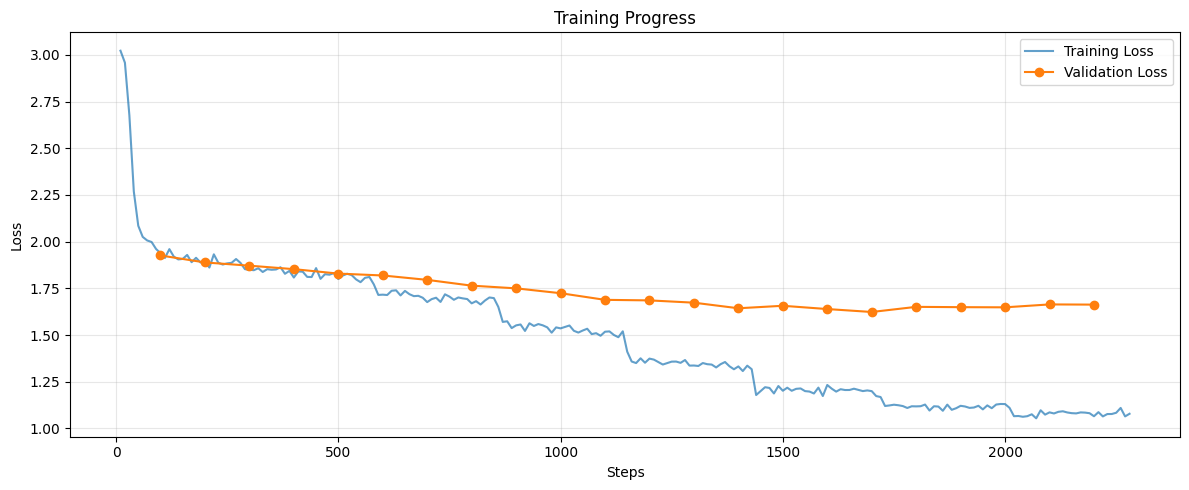

In [38]:
# Load training logs
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Find tensorboard logs
log_files = glob.glob(f"{OUTPUT_DIR}/logs/events.out.tfevents.*")

if log_files:
    event_acc = EventAccumulator(log_files[0])
    event_acc.Reload()
    
    # Extract training loss
    train_loss = event_acc.Scalars('train/loss') if 'train/loss' in event_acc.Tags()['scalars'] else []
    eval_loss = event_acc.Scalars('eval/loss') if 'eval/loss' in event_acc.Tags()['scalars'] else []
    
    if train_loss:
        # Plot losses
        fig, ax = plt.subplots(figsize=(12, 5))
        
        steps = [s.step for s in train_loss]
        values = [s.value for s in train_loss]
        ax.plot(steps, values, label='Training Loss', alpha=0.7)
        
        if eval_loss:
            eval_steps = [s.step for s in eval_loss]
            eval_values = [s.value for s in eval_loss]
            ax.plot(eval_steps, eval_values, label='Validation Loss', marker='o')
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')
        ax.set_title('Training Progress')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No training metrics found in logs")
else:
    print("No TensorBoard logs found")

## 14. Next Steps 🎯

### What to do now:

1. **Evaluate your model** - Use the evaluation template:
   ```python
   # In evaluation_template.ipynb
   DIALOGUE_CHECKPOINT = "../checkpoints/dialogue_finetuned_v2/final"
   ```

2. **Experiment with hyperparameters:**
   - Try different LoRA ranks (4, 8, 16)
   - Adjust learning rate (1e-4 to 5e-4)
   - Increase training epochs
   - Experiment with context window size

3. **Try emotion conditioning:**
   - Set `EMOTION_CONDITIONED = True`
   - Add emotion labels to your data
   - Re-train and compare

4. **Production deployment:**
   - Use `scripts/train.py` for longer training runs
   - Monitor with TensorBoard
   - Save checkpoints regularly

### Troubleshooting:

**Out of Memory?**
- Reduce `batch_size` to 1
- Increase `gradient_accumulation_steps`
- Reduce `max_length`
- Lower `lora_r`

**Training too slow?**
- Enable `bf16` if supported
- Reduce `eval_steps` and `save_steps`
- Use smaller validation set

**Poor quality outputs?**
- Train for more epochs
- Increase `lora_r`
- Add more training data
- Tune generation parameters (temperature, top_p)